In [1]:
def calc_distance(v_error_pos,p_error_pos,nbr_vertex_error,nbr_plaquette_error):
    
    vertex_distance = np.zeros(nbr_vertex_error)
    plaquette_distance = np.zeros(nbr_plaquette_error)
    
    for ix in range(nbr_vertex_error-1):
        vertex_distance[ix] = abs(v_error_pos[ix+1,0]-v_error_pos[ix,0])
        vertex_distance[ix+1] = abs(v_error_pos[ix+1,1]-v_error_pos[ix,1])

    for ix in range(nbr_plaquette_error-1):
        plaquette_distance[ix] = abs(p_error_pos[ix+1,0]-p_error_pos[ix,0])
        plaquette_distance[ix+1] = abs(p_error_pos[ix+1,1]-p_error_pos[ix,1])
    
    for ix in range(int(nbr_plaquette_error*(nbr_plaquette_error-1)/2)):
        plaquette_defect_distance = np.sqrt(plaquette_distance[0]**2+plaquette_distance[1]**2)
    
    for ix in range(int(nbr_vertex_error*(nbr_vertex_error-1)/2)):    
        vertex_defect_distance = np.sqrt(vertex_distance[0]**2+vertex_distance[1]**2)
    
    return vertex_defect_distance,plaquette_defect_distance

def calc_cross_distance(v_error_pos,p_error_pos,nbr_vertex_error,nbr_plaquette_error):
    crossover_distance = np.zeros((4,2))
    c_distance = np.zeros(4)
    
    for ix in range(nbr_vertex_error):
        for jx in range(nbr_plaquette_error):
            crossover_distance[ix*2+jx,0] = abs(v_error_pos[ix,0]-(p_error_pos[jx,0]+0.5))   
            crossover_distance[ix*2+jx,1] = abs(v_error_pos[ix,1]-(p_error_pos[jx,1]+0.5))   

    for ix in range(nbr_vertex_error+nbr_plaquette_error):
        c_distance[ix] = np.sqrt(crossover_distance[ix,0]**2+crossover_distance[ix,1]**2)
        
    return c_distance

def mirror_positions(v_error_pos,p_error_pos,nbr_vertex_error,nbr_plaquette_error,size=5):

    distances_pmirror = np.zeros(nbr_plaquette_error)
    distances_vmirror = np.zeros(nbr_vertex_error)
    distances_pmirror = np.zeros(nbr_plaquette_error)
    distances_vmirror = np.zeros(nbr_vertex_error)

    
    p_error_pos = p_error_pos+1#change from index notation of position to acual position
    v_error_pos = v_error_pos+1
        
    for ix in range(nbr_plaquette_error):
        if(p_error_pos[ix][1]>= 2.5):
            #print(p_error_pos[ix][1])
            distances_pmirror[ix] = -(size-p_error_pos[ix][1])
        else:
            #print(p_error_pos[ix][1])
            distances_pmirror[ix] =p_error_pos[ix][1]
        
    for ix in range(nbr_vertex_error):
        if(v_error_pos[ix][0]>=2.5):
            distances_vmirror[ix] = -(size-v_error_pos[ix][0])#size = 5
            #normalized_v = 2*(distances_vmirror[ix]-1)/((size-1)-1)-1 
    
        else:
            distances_vmirror[ix] = v_error_pos[ix][0]
            #normalized_v = 2*(distances_vmirror[ix]-1)/((size-1)-1)-1 
    
            
    #NORMALIZATION
    for ix in range(nbr_vertex_error):
        distances_vmirror[ix] = distances_vmirror[ix]/2 #must change this norm for different sizes 
        
    for ix in range(nbr_plaquette_error):
        distances_pmirror[ix] = distances_pmirror[ix]/2 

    return distances_vmirror,distances_pmirror
        



In [150]:
def syndrome_to_graph(qubit_matrix,graph_idx):
    
    nbr_defects = np.count_nonzero(qubit_matrix)
    nbr_vertex_error = np.count_nonzero(qubit_matrix[0])
    nbr_plaquette_error = np.count_nonzero(qubit_matrix[1])
    
    adj_matrix = np.ones((nbr_defects,nbr_defects))
    np.fill_diagonal(adj_matrix,0)#fully connected so easy matrix

    mix_edge_distance = np.zeros(4)
    mirror_defects_v = np.zeros(nbr_vertex_error)
    mirror_defects_p = np.zeros(nbr_plaquette_error)
    
    
    vertex_error_positions = np.argwhere(qubit_matrix[0])
    plaquette_error_positions = np.argwhere(qubit_matrix[1])
    
    vertex_edge_distance, plaquette_edge_distance = calc_distance(vertex_error_positions,plaquette_error_positions,nbr_vertex_error,nbr_vertex_error)
    
    mix_edge_distance = calc_cross_distance(vertex_error_positions,plaquette_error_positions,nbr_vertex_error,nbr_plaquette_error)
    
    mirror_defects_v,mirror_defects_p = mirror_positions(vertex_error_positions,plaquette_error_positions,nbr_vertex_error,nbr_plaquette_error)
    #print(mirror_defects_v,mirror_defects_p)
    
    file_mirror = open('my_dataset/node_features.txt','a')
    for ix in range(nbr_defects):
        if ix <= nbr_vertex_error-1:
            file_mirror.write(str(ix)+' '+str(mirror_defects_v[ix])+' '+"v"+"\n")
        else: file_mirror.write(str(ix)+' '+str(mirror_defects_p[ix-nbr_vertex_error])+' '+"p"+"\n")
    file_mirror.close()
    
    adj_matrix[0,:] = adj_matrix[0,:]*[1,vertex_edge_distance,mix_edge_distance[0],mix_edge_distance[1]]
    adj_matrix[1,:] = adj_matrix[1,:]*[vertex_edge_distance,1,mix_edge_distance[2],mix_edge_distance[3]]
    adj_matrix[2,:] = adj_matrix[2,:]*[mix_edge_distance[0],mix_edge_distance[2],1,plaquette_edge_distance]
    adj_matrix[3,:] = adj_matrix[3,:]*[mix_edge_distance[1],mix_edge_distance[3],plaquette_edge_distance,1]
    
    
    file_1 = open('my_dataset/graph_idx.txt','a')
    
    nbr_of_edges = nbr_defects*(nbr_defects-1)/2
    for jx in range(int(nbr_of_edges)):
        file_1.write(str(graph_idx)+"\n")
    file_1.close()
    
    
    return adj_matrix
    
    #print(distance_vector)
    
def plot_graph(adj_matrix):
    import networkx as nx
    import matplotlib.pyplot as plt
    
    graph = nx.from_numpy_matrix(adj_matrix)
    layout= nx.spring_layout(graph)
    nx.draw(graph,with_labels=True)
    labels = nx.get_edge_attributes(graph,"length")
    nx.draw_networkx_edge_labels(graph,pos=layout,edge_labels=labels,font_size=8)

    
    
    file_2 = open('my_dataset/edgelist.txt','ab')        
    nx.write_edgelist(graph, file_2)
    



In [37]:
import copy  # not used
import os
import sys
import time

import numpy as np
import pandas as pd

from src.mcmc import *

size = 5
iterator = MCMCDataReader('./data/data_size_5_method_STDC_id_1_perror_0.1.xz', size)
data = iterator.full()

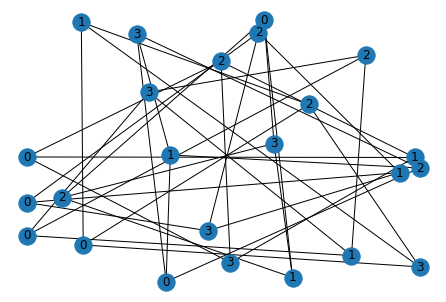

In [153]:
ix=0
#int(len(data)/2)
for k in range(100):
        qubit_matrix = data[2*k].reshape(2,size,size)
        eq_distr = data[2*k+1]
        
        if np.count_nonzero(qubit_matrix[0])==2 and np.count_nonzero(qubit_matrix[1])==2:

            file_graph_label = open('my_dataset/graph_label.txt','a')
            file_graph_label.write(str(np.argmax(eq_distr))+'\n')

            
            adjacency_matrix = syndrome_to_graph(qubit_matrix,ix)
            plot_graph(adjacency_matrix)
            ix=ix+1
            
            #syndrome_to_graph(qubit_matrix)

#file_2.close()

[3.35606559e-01 1.38880316e-06 9.96639441e+01 4.47961577e-04]
